<h1> The Challenge:</h1>

Based off this dataset with school financial, enrollment, and achievement data, we are interested in what information is a useful indicator of student performance at the state level.

This question is a bit too big for a checkpoint, however. Instead, we want you to look at smaller questions related to our overall goal. Here's the overview:

1. Choose a specific test to focus on
>Math/Reading for 4/8 grade
* Pick or create features to use
>Will all the features be useful in predicting test score? Are some more important than others? Should you standardize, bin, or scale the data?
* Explore the data as it relates to that test
>Create 2 well-labeled visualizations (graphs), each with a caption describing the graph and what it tells us about the data
* Create training and testing data
>Do you want to train on all the data? Only data from the last 10 years? Only Michigan data?
* Train a ML model to predict outcome 
>Pick if you want to do a regression or classification task. For both cases, defined _exactly_ what you want to predict, and pick any model in sklearn to use (see sklearn <a href="https://scikit-learn.org/stable/modules/linear_model.html">regressors</a> and <a href="https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html">classifiers</a>).
* Summarize your findings
>Write a 1 paragraph summary of what you did and make a recommendation about if and how student performance can be predicted

** Include comments throughout your code! Every cleanup and preprocessing task should be documented.


Of course, if you're finding this assignment interesting (and we really hope you do!), you are welcome to do more than the requirements! For example, you may want to see if expenditure affects 4th graders more than 8th graders. Maybe you want to look into the extended version of this dataset and see how factors like sex and race are involved. You can include all your work in this notebook when you turn it in -- just always make sure you explain what you did and interpret your results. Good luck!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# feel free to import other libraries! 

In [26]:
df = pd.read_csv('../data/states_edu.csv')

Chosen test: Average Math scores for 8th graders

<h2> Cleanup (optional)</h2>

_Use this space to rename columns, deal with missing data, etc._

In [27]:
# rename columns for easier use
df.rename({
    'GRADES_PK_G':'ENROLL_PREK',
    'GRADES_KG_G':'ENROLL_KINDER',
    'GRADES_4_G':'ENROLL_4',
    'GRADES_8_G':'ENROLL_8',
    'GRADES_12_G':'ENROLL_12',
    'GRADES_1_8_G':'ENROLL_PRIMARY',
    'GRADES_9_12_G':'ENROLL_HS',
    'GRADES_ALL_G':'ENROLL_ALL',
    'ENROLL':'ENROLL_ALL_EST',
    'AVG_MATH_4_SCORE':'MATH_4',
    'AVG_MATH_8_SCORE':'MATH_8',
    'AVG_READING_4_SCORE':'READING_4',
    'AVG_READING_8_SCORE':'READING_8'
    },
    axis=1,inplace=True)

In [28]:
# remove Nan values from the chosen test, MATH_8
df.dropna(subset=['MATH_8', 'ENROLL_ALL', 'INSTRUCTION_EXPENDITURE', 'ENROLL_4', 'ENROLL_8'], inplace=True)

<h2> Feature Selection </h2>

_Use this space to modify or create features_

In [29]:
# for each row in df, find the amount spent on instruction per student
df['INSTRUCTION_EXPENDITURE_PER_STUDENT'] = df['INSTRUCTION_EXPENDITURE'] / df['ENROLL_ALL']

# initialize CHANGE_IN_ENROLL column to 0s
df['CHANGE_IN_ENROLL'] = df['ENROLL_8'] * 0

# for each row, find 'previous' rows from 4 years earlier
for i, row in df.iterrows():
    for prev_i, prev_row in df.iterrows():
        if prev_row['YEAR'] == row['YEAR'] - 4 and prev_row['STATE'] == row['STATE']:

            # calculate the rational change in enrollment from 4th to 8th grades
            df.at[i, 'CHANGE_IN_ENROLL'] = row['ENROLL_8'] / prev_row['ENROLL_4']

# segment the change in enrollment into bins
df['CHANGE_IN_ENROLL'] = pd.cut((df['CHANGE_IN_ENROLL']), [-0.01, 0.01, 0.92, 0.98, 1.02, 1.08, 1000], labels=['no data', 'major decrease', 'decrease', 'no change', 'increase', 'major increase'])

Final feature list:

**INSTRUCTION_EXPENDITURE_PER_STUDENT, CHANGE_IN_ENROLL**

Feature selection justification:

**INSTRUCTION_EXPENDITURE_PER_STUDENT:** This feature represents the amount of money spent on instruction per student. I hear a lot that teachers should be paid more, so I am interested to see if there is any correlation between the amount spent on teachers for every student and those students' test scores.

**CHANGE_IN_ENROLL:** This feature will be used to examine how the growth or decline of a student population corresponds to test scores. The feature uses bins to compare the ratio of student enrollments between 4th grade and 8th grade.

<h2> EDA </h2>

Visualization 1

<AxesSubplot:xlabel='INSTRUCTION_EXPENDITURE_PER_STUDENT', ylabel='MATH_8'>

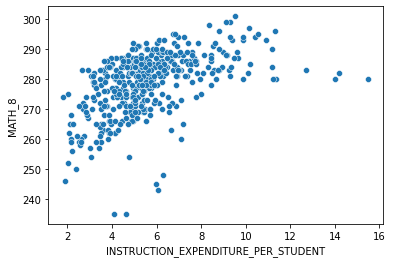

In [30]:
# create a scatterplot comparing the instructional expenditure per student to test scores
sns.scatterplot(data=df, x='INSTRUCTION_EXPENDITURE_PER_STUDENT', y='MATH_8')

The scatterplot shows a moderate relation between teacher pay and 8th grade math scores. There are some outliers with high pay and moderate test scores, or moderate pay and low test scores, but more data are clearly in a large group that does seem to show correlation (not causation) between instruction expenditure per student and math scores.

Visualization 2

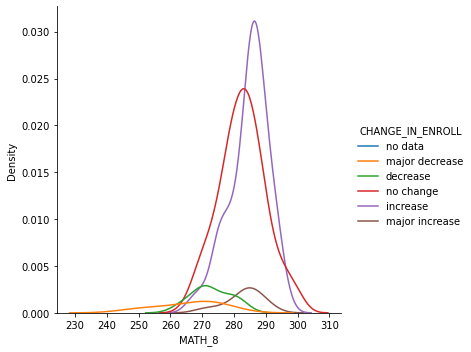

In [31]:
sns.displot(data=df[df['CHANGE_IN_ENROLL'] != 'no data'], x='MATH_8', kind='kde', hue='CHANGE_IN_ENROLL')

While the amount of data is limited for schools with decreasing enrollment, the peak of each curve demonstrates that growing classes have noticeably higher test scores. This is best observed between the 'no change' and 'increase' distributions, where the peak of the 'increasing' curve is about 5 points higher than that of the 'unchanging' curve.

<h2> Data Creation </h2>

_Use this space to create train/test data_

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
df = df[df['CHANGE_IN_ENROLL'] != 'no data']
df = pd.get_dummies(df, columns=['CHANGE_IN_ENROLL'])
X = df[['INSTRUCTION_EXPENDITURE_PER_STUDENT',
        'CHANGE_IN_ENROLL_major decrease',
        'CHANGE_IN_ENROLL_decrease',
        'CHANGE_IN_ENROLL_no change',
        'CHANGE_IN_ENROLL_increase',
        'CHANGE_IN_ENROLL_major increase']]
y = df.loc[X.index]['MATH_8']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=0)

<h2> Prediction </h2>

Chosen ML task: **REGRESSION**

In [35]:
# import sklearn class
from sklearn.linear_model import LinearRegression

In [36]:
# create model
model = LinearRegression()

In [37]:
# fit model to training data
model.fit(X_train, y_train)

LinearRegression()

In [38]:
y_pred = model.predict(X_test)

Text(0, 0.5, 'GRADE 8 MATH SCORE')

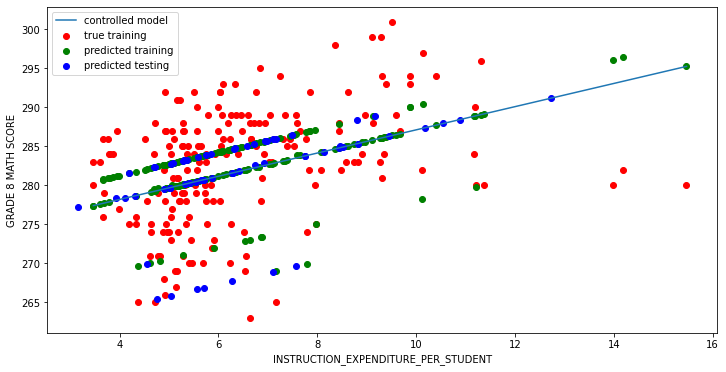

In [39]:
# FOR REGRESSION ONLY: (pick a single column to visualize results)

# Results from this graph _should not_ be used as a part of your results -- it is just here to help with intuition. 
# Instead, look at the error values and individual intercepts.


col_name = 'INSTRUCTION_EXPENDITURE_PER_STUDENT'
col_index = X_train.columns.get_loc(col_name)

f = plt.figure(figsize=(12,6))
plt.scatter(X_train[col_name], y_train, color = "red")
plt.scatter(X_train[col_name], model.predict(X_train), color = "green")
plt.scatter(X_test[col_name], model.predict(X_test), color = "blue")

new_x = np.linspace(X_train[col_name].min(),X_train[col_name].max(),200)
intercept = model.predict([X_train.sort_values(col_name).iloc[0]]) - X_train[col_name].min()*model.coef_[col_index]
plt.plot(new_x, intercept+new_x*model.coef_[col_index])

plt.legend(['controlled model','true training','predicted training','predicted testing'])
plt.xlabel(col_name)
plt.ylabel('GRADE 8 MATH SCORE')

In [40]:
print(model.intercept_)
print(model.coef_)

268.34396765373396
[ 1.48620346 -9.95094105 -5.15423954  3.9150094   6.98199482  4.20817638]


In [41]:
model.score(X_test, y_test)

0.5335471143488806

In [42]:
np.mean(model.predict(X_test)-y_test)

-0.9035088782092089

In [43]:
np.mean(np.abs(model.predict(X_test)-y_test))

4.952625765674085

In [44]:
np.mean((model.predict(X_test)-y_test)**2)**0.5

6.261366027825092

In [45]:
np.std(y_test)

9.16780148041912

<h2> Summary </h2>

In this notebook, education data from the past few decades is used to attempt to predict the average 8th grade math scores of states. Specifically, instruction expenditures and the change in enrollment between 4th and 8th grade are used to create a linear regression model. This linear model had a root mean squared error of 6.2614 points; the standard deviation of average scores in the test bin is 9.1678, so the model is somewhat effective. Further, the model's R^2 score is 0.5335, so about 53% of the variation in the data is accounted for by the model. This shows that while instruction expenditure and enrollment rates are not a perfect tell-tale of 8th grade math scores, there is some correlation. We cannot conclude that there is causation.